# Markov Random Fields
## An image de-noising example

A random markov field is a model of a nondirected probabilistic graph such that can be written as

$$
    p({\bf x}) = \frac{1}{Z} \prod_c\psi_c({\bf x}_c)
$$

Where $Z = \sum_{\bf x}\prod_c \psi_c({\bf x}_c)$, and the product runs over the *maximal* cliques in the graph.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from numpy.random import seed, random

In [2]:
from numba import jit

In [3]:
%config InlineBackend.figure_format = "retina"

In [4]:
img = imread("img.jpeg", as_gray=True)
img_shape = img.shape
img = np.round(img)
img.shape

(576, 598)

Let $\{y_i\}_i$ be the pixels of an observed noisy image. We suppose that the noisy image was generated using a noise-free image with pixels $\{x_i\}_i$ and randomly flippning the signs of the pixel with some small probability

In [5]:
final_noisy = np.copy(img)
# p(flip) = 0.1
mmap = random(size=(img_shape)) <= 0.1
final_noisy[mmap] = np.abs(final_noisy[mmap] - 1)

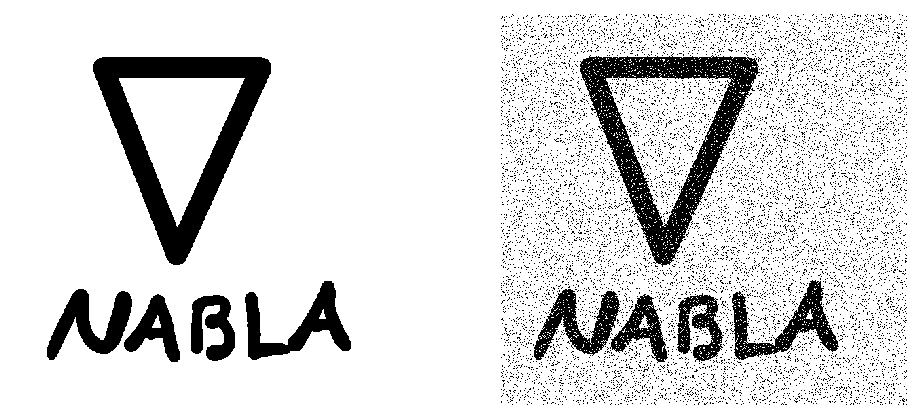

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(img, cmap="bone")
ax[1].imshow(final_noisy, cmap="bone")
ax[0].axis("off")
ax[1].axis("off");

Our energy function is given by
$$
    E({\bf x}, {\bf y}) = h\sum_ix_i - \beta \sum_{\{i,j\}}x_ix_j - \eta\sum_ix_iy_i 
$$

In [7]:
y = final_noisy.copy() * 2 - 1
x = final_noisy.copy() * 2 - 1

In [81]:
def find_neighbors(x, i, j):
    """
    Cannot be used with numba
    """
    nx, ny = x.shape
    neighbors = np.array([(i, j + 1), (i + 1, j),
                          (i - 1, j), (i, j - 1)])
    filter1 = ~(neighbors < 0).any(axis=1)
    filter2 = ~(neighbors >= np.array(x.shape)).any(axis=1)
    filter_final = filter1 & filter2
    return neighbors[filter_final].T


@jit(nopython=True)
def find_neighbors(x, i, j):
    """
    """
    nx, ny = x.shape
    rows, cols = [], []
    if i > 0:
        rows.append(i - 1)
        cols.append(j)
    if j > 0:
        rows.append(i)
        cols.append(j - 1)
    if i < nx - 1:
        rows.append(i + 1)
        cols.append(j)
    if j < ny - 1:
        rows.append(i)
        cols.append(j + 1)
        
    return rows, cols


@jit(nopython=True)
def E(x, y, h=0, beta=0.1, eta=2.1):
    total_energy = h * x.sum() - eta * (x * y).sum()
    total_energy = 0
    nx, ny = x.shape
    for i in range(nx):
        for j in range(ny):
            
            rows, cols = find_neighbors(x, i, j)
                
            neighbor_energy = 0.
            for row, col in zip(rows, cols):
                neighbor_energy = neighbor_energy + x[row, col] * x[i, j]
            
            #neighbors = x[rows, cols]
            #neighbor_energy = (neighbors * x[i, j]).sum()
            total_energy = total_energy - beta * neighbor_energy
            
    return total_energy


@jit(nopython=True)
def neighbor_energy(x, i, j, beta):
    """
    Sum of energies in the neighborhood
    """
    rows, cols = find_neighbors(x, i, j)
    energy = 0.
    for row, col in zip(rows, cols):
        energy = energy + x[row, col] * x[i, j]
    return beta * energy

@jit(nopython=True)
def local_energy(x, y, i, j, h=0, beta=0.1, eta=2.1):
    neigh_energy = neighbor_energy(x, i, j, beta)
    energy = h * x[i, j] - eta * x[i, j] * y[i, j] - neigh_energy
    return energy

In [82]:
%%time
E(x, y)

CPU times: user 466 ms, sys: 5.17 ms, total: 471 ms
Wall time: 471 ms


0.40000000000000013

In [11]:
@jit(nopython=True)
def update_pixels(x, y):
    nx, ny = x.shape
    x = x.copy()
    for i in range(nx):
        for j in range(ny):
            org = x[i, j]
            x[i,j] = 1
            energy_plus = E(x, y)
            
            x[i,j] = -1
            energy_minus = E(x, y)
                
            # Go to the state with lower energy
            if energy_plus < energy_minus:
                x[i,j] = 1
            else:
                x[i,j] = -1
                
    return x

In [ ]:
%%time
res = update_pixels(x, y)

## A smaller example
**(since nothing seems to be working)**

In [200]:
y = np.array([
    [1, 0, 0],
    [0, 1, 1],
    [0, 0, 1]
])

y = 2 * y - 1

def show_grid(x):
    plt.pcolor(x[::-1], cmap="bone_r", linewidths=3, edgecolors="tab:gray")
    plt.xticks([])
    plt.yticks([])

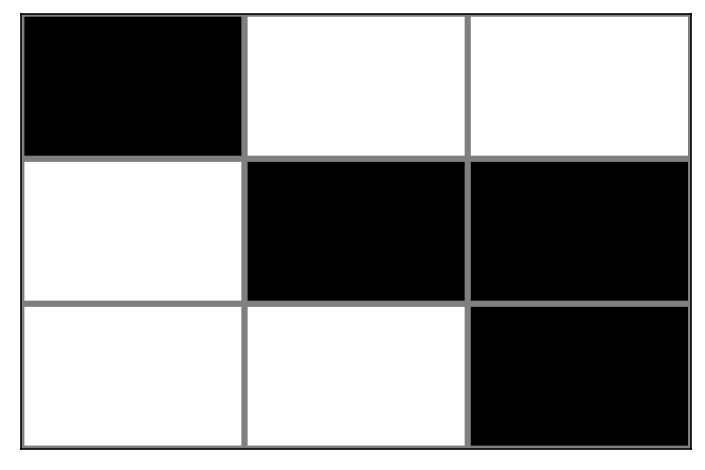

In [201]:
show_grid(y)

In [202]:
x = y.copy()

In [210]:
E(x, y)

0.40000000000000013

**To-do**: Reproduce with local energy

In [214]:
nx, ny = x.shape
for i in range(nx):
    for j in range(ny):
        x[i, j] = 1
        e_plus = E(x, y)
        x[i, j] = -1
        e_minus = E(x, y)
        
        print(f"{e_minus:0.2f}, {e_plus:0.2f}", end=" ")
        
        if e_plus < e_minus:
            print("plus")
            x[i, j] = 1
        else:
            print("minus")
            x[i, j] = -1

-0.40, 0.40 minus
-0.40, 0.00 minus
-0.40, -0.40 minus
-0.40, 0.00 minus
-1.20, -0.40 minus
-1.60, -1.20 minus
-1.60, -0.80 minus
-1.60, -1.20 minus
-2.40, -1.60 minus


In [215]:
E(x, y)

-2.4000000000000004

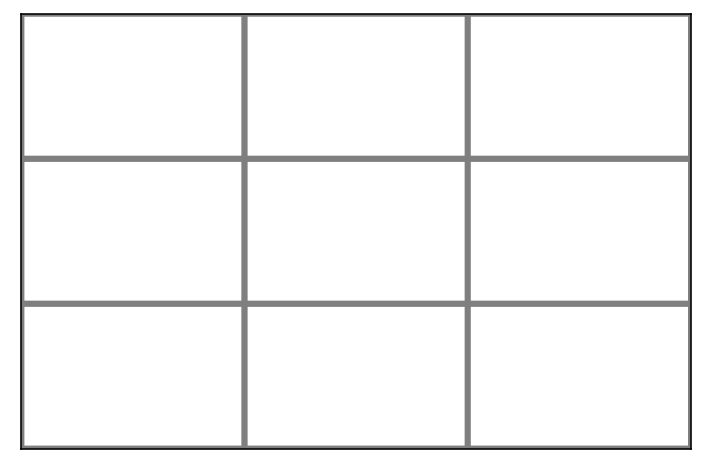

In [216]:
show_grid(x)